In [1]:
import sys
from pathlib import Path
from dataclasses import dataclass

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

In [2]:
@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"


config = Config()

sys.path.append(str(config.REPO_ROOT))

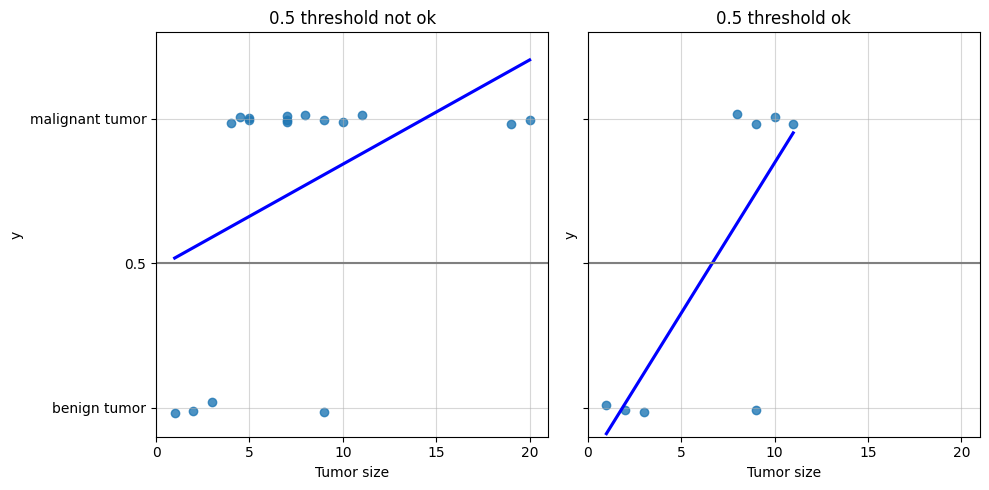

In [3]:
# TODO
# レイアウト合わせる
df = pd.DataFrame(
    {
        "x": [1, 2, 3, 8, 9, 10, 11, 9],
        "y": [0, 0, 0, 1, 1, 1, 1, 0],
        "case": "0.5 threshold ok",
    }
)

df_extra = pd.DataFrame(
    {
        "x": df["x"].tolist() + [7, 7, 7, 20, 19, 5, 5, 4, 4.5],
        "y": df["y"].tolist() + [1, 1, 1, 1, 1, 1, 1, 1, 1],
        "case": "0.5 threshold not ok",
    }
)

df_lin_log = pd.concat([df, df_extra])
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
for ax, (case, title) in zip(
    axes.flat,
    [
        ("0.5 threshold not ok", "0.5 threshold not ok"),
        ("0.5 threshold ok", "0.5 threshold ok"),
    ],
):
    df_subset = df_lin_log[df_lin_log["case"] == case]

    # Jitter the y-values *before* plotting
    jittered_y = df_subset["y"] + np.random.uniform(-0.02, 0.02, len(df_subset))

    sns.regplot(
        x="x", y=jittered_y, data=df_subset, ax=ax, ci=None, line_kws={"color": "blue"}
    )

    ax.set_title(title)
    ax.set_xlabel("Tumor size")
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(["benign tumor", "0.5", "malignant tumor"])
    ax.set_ylim(-0.1, 1.3)
    ax.set_xlim(0, 21)
    ax.set_xticks([i * 5 for i in range(5)])
    ax.axhline(y=0.5, linestyle="-", color="gray")
    ax.grid(True, linestyle="-", alpha=0.5)
plt.tight_layout()  # Adjusts subplot parameters for a tight layout.
plt.show()

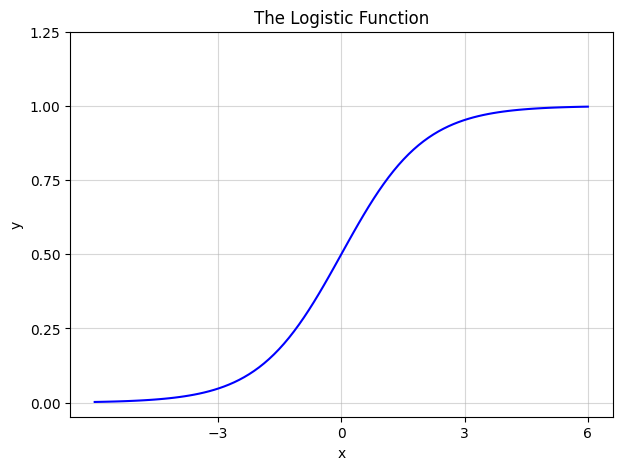

In [4]:
# Define the logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x))


x = np.linspace(-6, 6, 100)
y = logistic(x)
fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharey=True)
ax.plot(x, y, color="blue")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xticks([i * 3 for i in range(-1, 3)])
ax.set_yticks([i * 0.25 for i in range(6)])
ax.set_title("The Logistic Function")
ax.grid(True, linestyle="-", alpha=0.5)
plt.show()


Optimization terminated successfully.
         Current function value: 0.308350
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.417795
         Iterations 7


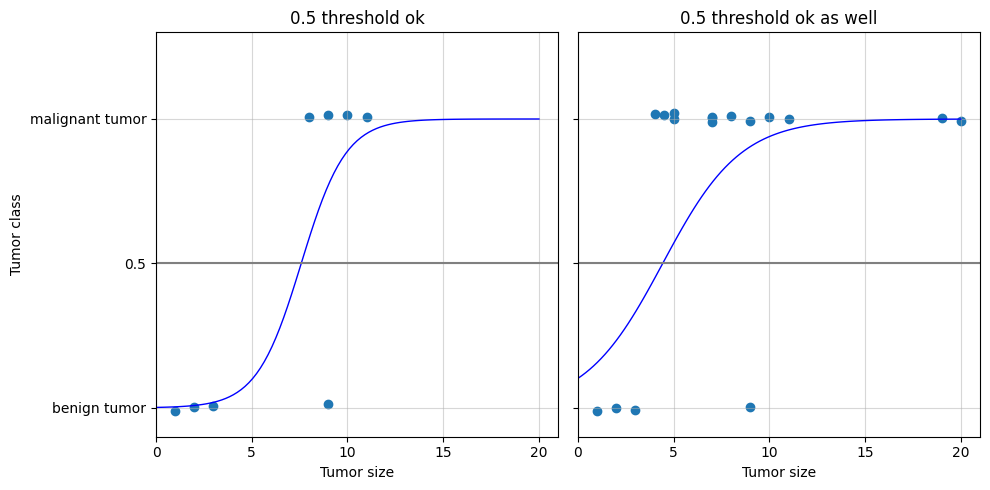

In [5]:
# TODO
# レイアウト合わせる

df_lin_log = pd.concat([df, df_extra])
df_lin_log["case"] = df_lin_log["case"].astype(str)
df_lin_log["case"] = df_lin_log["case"].replace(
    "0.5 threshold not ok", "0.5 threshold ok as well"
)

X1 = sm.add_constant(df[df["case"] == "0.5 threshold ok"][["x"]])
y1 = df[df["case"] == "0.5 threshold ok"]["y"]
model1 = sm.Logit(y1, X1).fit()

X2 = sm.add_constant(df_lin_log[["x"]])
y2 = df_lin_log["y"]
model2 = sm.Logit(y2, X2).fit()

# 予測値を生成
lgrid = pd.DataFrame({"x": np.linspace(0, 20, 100)})
X1_grid = sm.add_constant(lgrid[["x"]])
lgrid["y1_pred"] = model1.predict(X1_grid)

X2_grid = sm.add_constant(lgrid[["x"]])
lgrid["y2_pred"] = model2.predict(X2_grid)

# データフレームの整形
lgrid_m = lgrid.melt(id_vars="x", var_name="case", value_name="value")
lgrid_m["case"] = lgrid_m["case"].replace(
    {"y1_pred": "0.5 threshold ok", "y2_pred": "0.5 threshold ok as well"}
)

# プロット
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
for ax, case in zip(axes.flat, ["0.5 threshold ok", "0.5 threshold ok as well"]):
    df_subset = df_lin_log[df_lin_log["case"] == case]
    lgrid_subset = lgrid_m[lgrid_m["case"] == case]

    jittered_y = df_subset["y"] + np.random.uniform(-0.02, 0.02, len(df_subset))
    ax.plot(lgrid_subset["x"], lgrid_subset["value"], color="blue", linewidth=1)
    ax.scatter(df_subset["x"], jittered_y)
    ax.set_title(case)
    ax.set_xlabel("Tumor size")
    ax.set_xlim(0, 21)
    ax.set_xticks([i * 5 for i in range(5)])
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(["benign tumor", "0.5", "malignant tumor"])
    ax.set_ylim(-0.1, 1.3)
    ax.axhline(y=0.5, linestyle="-", color="gray")
    ax.grid(True, linestyle="-", alpha=0.5)

axes[0].set_ylabel("Tumor class")
plt.tight_layout()
plt.show()

In [6]:
from python.src.preprocess import preprocess_rfcc

df_rfcc = pd.read_csv(config.data_dir / "risk_factors_cervical_cancer.csv")
df_rfcc_preprocessed = preprocess_rfcc(df_rfcc)

In [7]:
X = df_rfcc_preprocessed[
    [
        "Hormonal Contraceptives",
        "Smokes",
        "Num of pregnancies",
        "STDs: Number of diagnosis",
        "IUD",
    ]
]
X = X.astype(float)
y = df_rfcc_preprocessed["Biopsy"]
y = y.map({"Healthy": 0, "Cancer": 1})
y = y.astype(int)

In [8]:
X = add_constant(X)
model = sm.Logit(y, X)
result = model.fit()

summary_table = result.summary2().tables[1]
summary_table = summary_table[["Coef.", "Std.Err."]]
summary_table["Odds Ratio"] = np.exp(summary_table["Coef."])
summary_table.columns = ["Weight", "Std.Error", "Odds Ratio"]
summary_table.index = [
    "Intercept",
    "Hormonal contraceptives y/n",
    "Smokes y/n",
    "Num. of pregnancies",
    "Num. of diagnosed STDs",
    "Intrauterine device y/n",
]
summary_table = summary_table[["Weight", "Odds Ratio", "Std.Error"]].round(2)

display(summary_table)

Optimization terminated successfully.
         Current function value: 0.232792
         Iterations 7


,Weight,Odds Ratio,Std.Error
Intercept,-2.91,0.05,0.32
Hormonal contraceptives y/n,-0.12,0.89,0.30
Smokes y/n,0.26,1.29,0.37
Num. of pregnancies,0.04,1.04,0.10
Num. of diagnosed STDs,0.82,2.26,0.33
Intrauterine device y/n,0.62,1.85,0.40
